In [2]:
#import toorch
import torch
import torchvision
import matplotlib.pyplot as plt

#import time,os etc
import time
import os
import numpy as np
import random
from distutils.version import LooseVersion as Version
from itertools import product

# **Settings**

In [68]:
def seed_setting(sd):
    os.environ["PL_GLOBAL_SEED"] = str(sd)
    random.seed(sd)
    np.random.seed(sd)
    torch.manual_seed(sd)
    torch.cuda.manual_seed_all(sd)


def fn_det_setting():
    
    #check if cuda is available
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    #check torch version
    if torch.__version__ <= Version("1.7"):
        torch.fn_det_setting(True)
    else:
        torch.use_deterministic_algorithms(True)

#set seed, batch size
RNDM_SEED = 245
btch_input_sz = 128
epch_nmbr = 25
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [69]:
seed_setting(RNDM_SEED)
#fn_det_setting() This may not work on Gpu because some algorithms are not deterministic on Gpu./

In [70]:
tr_ds_path = "/content/drive/MyDrive/car_img/tr" #Training Images
vd_ds_path = "/content/drive/MyDrive/car_img/vds" #Validation Images
ts_ds_path = "/content/drive/MyDrive/car_img/ts" #Test Images


In [71]:
##########################
### Custom DATASET
##########################
import torch.utils.data as data

tr_data_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(), #it converts data in the range 0-255 to 0-1.
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

validation_data_trans = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

tst_data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_ds_cln = torchvision.datasets.ImageFolder(root=tr_ds_path, transform= tr_data_trans)
train_loader_cln = data.DataLoader(train_ds_cln, btch_input_sz=206, shuffle=True)


test_ds_cln = torchvision.datasets.ImageFolder(root=ts_ds_path, transform= tst_data_transform)
test_loader_cln = data.DataLoader(test_ds_cln, btch_input_sz=206, shuffle=True)


valid_ds_cln = torchvision.datasets.ImageFolder(root=vd_ds_path, transform= validation_data_trans)
valid_loader_cln = data.DataLoader(valid_ds_cln, btch_input_sz=63, shuffle=True)




# Checking the dataset
for images, labels in train_loader_cln:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([206, 3, 64, 64])
Image label dimensions: torch.Size([206])
Class labels of 10 examples: tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 1])


# **Train Dataset**

In [72]:
for images, labels in train_loader_cln:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([206, 3, 64, 64])
Image label dimensions: torch.Size([206])
Class labels of 10 examples: tensor([0, 1, 0, 1, 1, 1, 1, 1, 0, 1])


In [73]:
tr_ds = images
tr_ds.shape

torch.Size([206, 3, 64, 64])

In [74]:
tr_label = labels
tr_label.shape

torch.Size([206])

# **Validation set**

In [75]:
for images, labels in valid_loader_cln:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([63, 3, 64, 64])
Image label dimensions: torch.Size([63])
Class labels of 10 examples: tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1])


In [76]:
vd_ds = images
vd_ds.shape

torch.Size([63, 3, 64, 64])

# **Test Dataset**

In [77]:
for images, labels in test_loader_cln:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([63, 3, 64, 64])
Image label dimensions: torch.Size([63])
Class labels of 10 examples: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0])


# **Load Pre-Trained Model**

In [78]:
model = torchvision.models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **Freezing the model**

Assume we want to fine-tune (train) the last 3 layers:

In [79]:
for param in model.parameters():
    param.requires_grad = False

In [80]:
model.classifier[1].requires_grad = True
model.classifier[3].requires_grad = True

For the last layer, because the number of class labels differs compared to ImageNet, we replace the output layer with your own output layer:

In [81]:
model.classifier[6] = torch.nn.Linear(4096, 2)

# **Training**

In [82]:
def find_acc_metric(input_model, input_data_ldr, dvc):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(input_data_ldr):

            features = features.to(dvc)
            targets = targets.float().to(dvc)

            preds = input_model(features)
            _, predicted_labels = torch.max(preds, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [83]:
def mdl_training(model, epch_nmbr, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):

    tme_strt = time.time()
    list_from_loss, accuracy_train, accuracy_validation = [], [], []
    
    for epoch in range(epch_nmbr):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader): #iterating over minibatches

            features = features.to(device) #Loading the data
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            preds = model(features) #prediction
            loss = torch.nn.functional.cross_entropy(preds, targets)
            optimizer.zero_grad() 

            loss.backward() #backpropagation

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            list_from_loss.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{epch_nmbr:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = find_acc_metric(model, train_loader, device=device)
            valid_acc = find_acc_metric(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{epch_nmbr:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            accuracy_train.append(train_acc.item())
            accuracy_validation.append(valid_acc.item())

        tr_time = (time.time() - tme_strt)/60
        print(f'Time tr_time: {tr_time:.2f} min')
        
        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(accuracy_validation[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(list_from_loss[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')
        

    tr_time = (time.time() - tme_strt)/60
    print(f'Final Training Time: {tr_time:.2f} min')

    test_acc = find_acc_metric(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return list_from_loss, accuracy_train, accuracy_validation

In [85]:
def Viz_acc(acc_training, val_acc, loc_res):

    epch_nmbr = len(acc_training)

    plt.plot(np.arange(1, epch_nmbr+1),
             acc_training, label='Training')
    plt.plot(np.arange(1, epch_nmbr+1),
             val_acc, label='Validation')

    plt.xlabel('# of Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if loc_res is not None:
        image_path = os.path.join(
            loc_res, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)

In [86]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

list_from_loss, accuracy_train, accuracy_validation = mdl_training(
    model=model,
    epch_nmbr=5,
    train_loader=train_loader_cln,
    valid_loader=valid_loader_cln,
    test_loader=test_loader_cln,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)


Epoch: 001/005 | Batch 0000/0001 | Loss: 1.4587
Epoch: 001/005 | Train: 79.13% | Validation: 76.21%
Time elapsed: 0.34 min
Epoch: 002/005 | Batch 0000/0001 | Loss: 0.8952
Epoch: 002/005 | Train: 92.72% | Validation: 90.29%
Time elapsed: 0.67 min
Epoch: 003/005 | Batch 0000/0001 | Loss: 0.3280
Epoch: 003/005 | Train: 97.57% | Validation: 96.60%
Time elapsed: 0.99 min
Epoch: 004/005 | Batch 0000/0001 | Loss: 0.1774
Epoch: 004/005 | Train: 99.03% | Validation: 96.60%
Time elapsed: 1.32 min
Epoch: 005/005 | Batch 0000/0001 | Loss: 0.0581
Epoch: 005/005 | Train: 99.51% | Validation: 98.06%
Time elapsed: 1.66 min
Total Training Time: 1.66 min
Test accuracy 100.00%


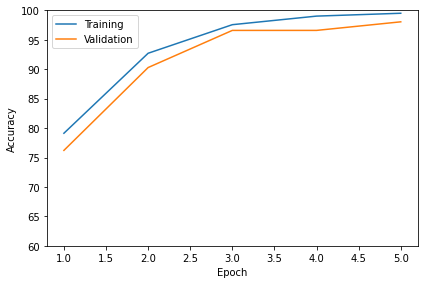

In [89]:
Viz_acc(accuracy_train=accuracy_train,
              accuracy_validation=accuracy_validation,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [90]:
def example_sample(model, data_loader, unnormalizer=None, class_dict=None):
    
        
    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            preds = model(features)
            predictions = torch.argmax(preds, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)
    
    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    
    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()

In [91]:
class UnNormalize(object): #for plotting the images
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


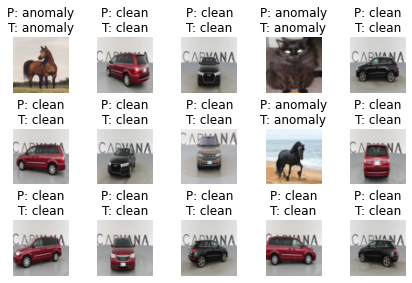

In [92]:
model.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict = {0: 'anomaly',
              1: 'clean'}

example_sample(model=model, data_loader=test_loader_cln, unnormalizer=unnormalizer, class_dict=class_dict)

In [93]:
def conf_matrix(model, input_data_ldr, input_dvc):

    trgt_data, pred_data = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(input_data_ldr):

            features = features.to(input_dvc)
            targets = targets
            preds = model(features)
            _, predicted_labels = torch.max(preds, 1)
            trgt_data.extend(targets.to('cpu'))
            pred_data.extend(predicted_labels.to('cpu'))

    pred_data = pred_data
    pred_data = np.array(pred_data)
    trgt_data = np.array(trgt_data)
        
    lable_values = np.unique(np.concatenate((trgt_data, pred_data)))
    if lable_values.shape[0] == 1:
        if lable_values[0] != 0:
            lable_values = np.array([0, lable_values[0]])
        else:
            lable_values = np.array([lable_values[0], 1])
    n_labels = lable_values.shape[0]
    lst = []
    z = list(zip(trgt_data, pred_data))
    for combi in product(lable_values, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

In [94]:
def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

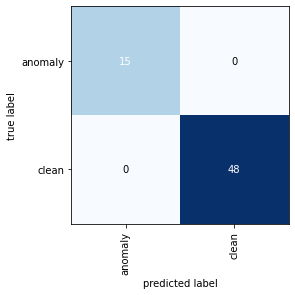

In [95]:
mat = conf_matrix(model=model, data_loader=test_loader_cln, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()